In [1]:
import pandas as pd

# plotting libraries
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
%config InlineBackend.figure_format = 'retina'
sns.set_style({'font.family':'sans-serif', 'font.sans-serif':'Arial'})
from matplotlib.ticker import MultipleLocator


In [2]:
reads = pd.read_csv('../data/16p12_lcl_gene_reads_underscores.gct', sep='\t')
tpm   = pd.read_csv('../data/16p12_lcl_gene_tpm_underscores.gct', sep='\t')
mapp  = pd.read_csv('../data/gene_names_mapping_new.tsv', sep='\t')
dis   = pd.read_csv('../data/disease_genes_map.tsv', sep='\t')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
dis = dis.set_index('ensembl', drop=False)
mapp = mapp.set_index('ensembl', drop=False)

reads['Name'] = reads['Name'].apply(lambda s: s.split('.')[0])
reads = reads.set_index('Name')

tpm['Name'] = tpm['Name'].apply(lambda s: s.split('.')[0])
tpm = tpm.set_index('Name')
tpm = tpm.drop('Description', axis=1)

dis_dbs = ['Developmental_delay_DDD','DBD','DDDG2P','SFARI_Gene','Purcell_Schiz']

In [4]:
genes_covered = pd.read_csv('lcl_expressed.txt', sep='\t', header=None)
genes_covered = list(genes_covered[0])

In [5]:
len(genes_covered)

24340

In [6]:
def database_pretty_name(s):
    if s == 'omim':
        return 'OMIM'
    if s == 'Developmental_delay_DDD':
        return 'DDD'
    if s == 'DBD':
        return 'DBD'
    if s == 'DDDG2P':
        return 'DDDG2P'
    if s == 'SFARI_Gene':
        return 'SFARI'
    if s == 'Purcell_Schiz':
        return 'Purcell'
    return 'na'

In [7]:
df = pd.DataFrame(columns = ['omim'] + dis_dbs).T
df['total_genes'] = 0
df['genes_covered'] = 0

for db in dis_dbs:
    db_genes = dis[dis[db] == 1].index.tolist()
    df.at[db, 'total_genes']   = len(db_genes)
    df.at[db, 'genes_covered'] = len(list(set(genes_covered) & set(db_genes)))

omim_genes = mapp[~mapp['mim_morbid_description'].isna()].ensembl.tolist()
df.at['omim', 'total_genes'] = len(omim_genes)
df.at['omim', 'genes_covered'] = len(list(set(genes_covered) & set(omim_genes)))

df['percent_cov'] = df['genes_covered'] / df['total_genes']
df['database'] = df.index.to_series().apply(database_pretty_name)


df

,total_genes,genes_covered,percent_cov,database
omim,2920,2176,0.745205,OMIM
Developmental_delay_DDD,513,451,0.879142,DDD
DBD,468,369,0.788462,DBD
DDDG2P,1845,1511,0.818970,DDDG2P
SFARI_Gene,740,547,0.739189,SFARI
Purcell_Schiz,2294,1850,0.806452,Purcell


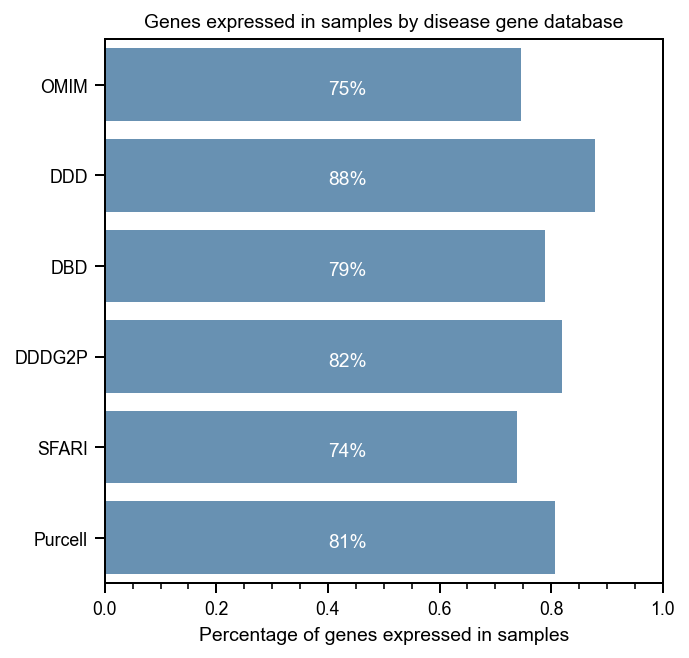

In [8]:
plt.figure(figsize=(5,5))
sns.set_context('paper', font_scale=1)

g = sns.barplot(
    data=df, 
    x='percent_cov', 
    y='database',
    color='#5C92BE'
)

g.set_ylabel(None)
g.set_xlabel('Percentage of genes expressed in samples')
g.set_title('Genes expressed in samples by disease gene database')

g.set_xlim([0,1])
g.get_xaxis().set_major_locator(matplotlib.ticker.MultipleLocator(.2))
g.get_xaxis().set_minor_locator(matplotlib.ticker.MultipleLocator(.05))

for i in range(len(df.index)):
    ind = df.index[i]
    text = '{0:.0%}'.format(df.at[ind, 'percent_cov'])
    g.text(.4, i+.1, text, color='white')

# plt.tight_layout()
plt.savefig('figures/S2a_disease_genes_bar.pdf', dpi=300)